In [ ]:
import mmf_setup;mmf_setup.nbinit()
%pylab inline --no-import-all
from nbimports import *            # Convenience functions like clear_output

<IPython.core.display.Javascript object>

## <font color='orange'> Error Analysis</font>

We start with the base BCS class which solves the problem in a 1D periodic universe.  This class will form the base for subsequent work, but is limited by the issue discussed above with discrete $k_n$.  As we shall see, there are two forms of errors: UV errors resulting from a limited $k_\max = \pi N/L$ and IR errors from the discrete $\d{k} = \pi/L$.  To estimate the UV errors, we consider the asymptotic form of the integrals:

$$
  \delta_{UV}\Delta = \frac{v_0}{2}\overbrace{2}^{\pm k}\int_{k_\max}^{\infty}
    \frac{\d{k}}{2\pi}\;\frac{\Delta}{\sqrt{\epsilon_+^2 + \Delta^2}} 
  \approx v_0\int_{k_\max}^{\infty} \frac{\d{k}}{2\pi}\;\frac{2m\Delta}{\hbar^2k^2}
  = \frac{v_0m\Delta}{\pi\hbar^2k_\max} + \frac{2v_0 m^2\mu_\mathrm{eff}}{3\pi\hbar^4k_\max^3},\\
  \delta_{UV}n_+ = 2\int_{k_\max}^{\infty}\frac{\d{k}}{2\pi}
    \left[1 - \frac{\epsilon_+}{\sqrt{\epsilon_+^2 + \abs{\Delta}^2}}\right]
  \approx \int_{k_\max}^{\infty}\frac{\d{k}}{2\pi}
    \frac{4m^2\abs{\Delta}^2}{\hbar^4k^4}
  = \frac{2m^2\abs{\Delta}^2}{3\pi\hbar^4k_{\max}^3} 
    + \frac{8m^3\mu_{\mathrm{eff}}\abs{\Delta}^2}{5\pi \hbar^6 k_\max^5}
$$

The error in $\Delta$ is largest, so we can set the lattice spacing to achieve the desired accuracy:

$$
  \frac{L}{N} \lesssim \frac{\pi^2\hbar^2}{v_0 m}\frac{\delta_{UV}\Delta}{\Delta}.
$$
Estimating the IR errors is more difficult: they arise from the variations of the integrand over the range $\d{k}$:
$$
  \frac{1}{\d{k}}\int_{-\d{k}/2}^{\d{k}/2}\d{k_b}\left\{
    \frac{\d{k}}{2\pi}\sum_{n}f(k_n + k_b)
  \right\} 
  \approx
  \frac{1}{\d{k}}\int_{-\d{k}/2}^{\d{k}/2}\d{k_b}\left\{
    \frac{\d{k}}{2\pi}\sum_{n}\left[f(k_n) + k_bf'(k_n) + \frac{k_b^2}{2}f''(k_n)\right]
  \right\}\\
  =
    \frac{\d{k}}{2\pi}\sum_{n}
    \left\{
      f(k_n)
      +
      \frac{\d{k}^2}{24}f''(k_n)
  \right\}.
$$

We thus expect the error to scale like 

$$
  \delta_{IR} \sim \frac{\d{k}^2}{24} = \frac{\pi^2}{3L^2}
$$

but the coefficient is difficult to calculate.

In [2]:
%pylab inline --no-import-all
from mmf_hfb import bcs;reload(bcs)
from mmf_hfb import homogeneous;reload(homogeneous)

Populating the interactive namespace from numpy and matplotlib


<module 'mmf_hfb.homogeneous' from 'E:\\Projects\\Physics\\quantum-fermion-theories\\mmf-hfb\\Docs\\..\\mmf_hfb\\homogeneous.py'>

In [5]:
delta = 1.0
mu_eff = 1.0
m = 1.0
N_twist = 4
v_0, n, mu, e_0 = homogeneous._get_BCS_v_n_e(delta=delta, mu_eff=mu_eff)
print(v_0,n,mu,e_0)
v_0, n, mu, e_0 = homogeneous.Homogeneous1D(m=m).get_BCS_v_n_e(delta=delta, mus_eff=(mu_eff,mu_eff),N_twist = N_twist)

v_0, n, mu, e_0 = v_0.n,(n[0].n,n[1].n),(mu[0].n,mu[1].n),e_0.n
n = n[0]+n[1]
print(v_0,n,mu,e_0)

def get_err(N, L, N_twist=1):
    b = bcs.BCS(T=0, Nxyz=(N,), Lxyz=(L,))
    n_a,n_b,kappa = b.get_densities(mus_eff=(mu_eff,mu_eff), delta=delta,N_twist=N_twist)
    #R = b.get_R(mus=(mu_eff, mu_eff), delta=delta, N_twist=N_twist)
    k_max = np.pi*N/L
    dn_UV = 2*b.m**2*delta**2/3/np.pi/k_max**3 + 8*b.m**3*mu_eff*delta**2/5/np.pi/k_max**5
    dd_UV = v_0*b.m*delta/np.pi/k_max + 2*v_0*b.m**2*mu_eff/3/np.pi/k_max**3
    return [[n_a[0].real + n_b[0].real, -v_0*kappa[0].real],[dn_UV, dd_UV]]

def get_errs(Ns, Ls, N_twist=1):
    Ns, Ls = np.asarray(Ns), np.asarray(Ls)
    res_NL = []
    res_UV = []
    for L in Ls:
        res_NL_ = []
        res_UV_ = []
        for N in Ns:
            n_d, d_UV = get_err(N=N, L=L, N_twist=N_twist)
            res_NL_.append(n_d)
            res_UV_.append(d_UV)
        res_NL.append(res_NL_)
        res_UV.append(res_UV_)
    return np.array([res_NL, res_UV])

2.201375025501774 0.8450714742610562 0.06984038089887279 -0.26275570174385876
2.201375025501774 0.845071474261069 (0.06984038089885869, 0.06984038089885869) -0.2627557004867941


In [ ]:
Ns = 2**np.arange(5, 9)
Ls = [1.0, 10.0, 30.0]
N_twists = [1, 2, 4]
plt.figure(figsize=(5*len(N_twists), 5))
for _n, N_twist in enumerate(N_twists):
    res_NL, res_UV = get_errs(Ns=Ns, Ls=Ls, N_twist=N_twist)
    n_, d_ = np.array(res_NL).T
    plt.subplot(101 + len(N_twists)*10 + _n)
    for _i, L in enumerate(Ls):
        _l, = plt.loglog(Ns, abs(n_[:, _i]-n)/n, '--+', label='$n({})$'.format(L), alpha=0.5)
        plt.loglog(Ns, abs(d_[:, _i]-delta)/delta, '--o', c=_l.get_c(),
                   label=r'$\Delta({})$'.format(L), alpha=0.5)
        plt.loglog(Ns, abs(res_UV[_i, :, 0])/n, ':', c=_l.get_c())
        plt.loglog(Ns, abs(res_UV[_i, :, 1])/delta, ':', c=_l.get_c())
    plt.ylabel('Rel err')
    plt.xlabel('N')
    plt.legend()
    plt.title("N_twist={}".format(N_twist))

This plot shows that our estimates of the UV errors is accurate, that the UV errors in $\Delta$ dominate, and that $L\approx 25$ is required for reasonable IR convergence.  The following plot shows that the IR errors are quite complicated in structure (shell effects).  Fortunately, we can reduce these errors by explicitly performing the **Bloch (twist) averaging**  (see examples [Lin:2001] ,[Kolorenc:2011]) as we shall describe below.


[Lin:2001]: https://arxiv.org/pdf/cond-mat/0101339.pdf 'Twist-averaged Boundary Conditions in Continuum Quantum Monte Carlo'

[Kolorenc:2011]: http://www.giovannibachelet.it/MitasRPP2011a.pdf 'Applications of quantum Monte Carlo methods in condensed systems'

Suppose we want a tolerance of $\delta \ln \Delta < 10^{-4}$, then we must have $L/N < 4.5$.  Computationally, we can conveniently work with $N=2^{10} = 1024$, so $L < 0.46$.

In [ ]:
L = 0.46
N = 2**8
N_twists = 2**np.arange(0,6)

res = np.array([get_err(N=N, L=L, N_twist=N_twist)[0]
                for N_twist in N_twists])
plt.loglog(N_twists, abs(res[:,0] - n)/n, '--+', label='$n$')
plt.loglog(N_twists, abs(res[:,1] - delta)/delta, '--o', label=r'$\Delta$')
plt.legend()

This plot shows that we need about $2^5=32$ points in the twist average to accurately determine the results.

In [ ]:
2**10*np.pi**2/v_0/m*1e-4

In [12]:
Ls = np.linspace(10.0, 30.0, 20)
res = []
for L in Ls:
    b = bcs.BCS(T=0, Nxyz=(2**10,), Lxyz=(L,))
    na,nb,kappa = b.get_densities(mus_eff=(mu_eff,mu_eff), delta=delta,N_twist=N_twist)

    res.append((na[0].real + nb[0].real, -v_0*kappa[0].real))
n_, d_ = np.array(res).T

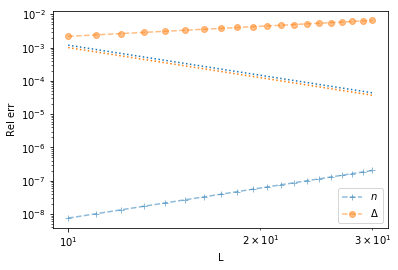

In [13]:
_l_n, = plt.loglog(Ls, abs(n_-n)/n, '--+', label='$n$', alpha=0.5)
_l_d, = plt.loglog(Ls, abs(d_-delta)/delta, '--o', label=r'$\Delta$', alpha=0.5)
plt.loglog(Ls, abs(1./Ls**3)/n, ':', c=_l_n.get_c())
plt.loglog(Ls, abs(1./Ls**3)/delta, ':', c=_l_d.get_c())

plt.ylabel('Rel err')
plt.xlabel('L')
plt.legend()